In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt
from matplotlib.cm import jet
%matplotlib inline

In [12]:
from background import NodeAndTimeAndMarkBackground, UniformTimeBackground, GaussianBackground
from clusters import NodeAndTimeAndMarkCluster, ExponentialTimeCluster, GaussianCluster
from models import DirichletProcessMixtureModel, NeymanScottModel
from util import permute_to_match, onehot, compute_state_overlap

from scipy.stats import norm, expon

In [13]:
npr.seed(12345)

In [14]:
# Make a Neyman-Scott model with gaussian marks
T = 100           # time window
M = 3             # number of nodes
data_dim = 2      # dimensionality of marks (e.g. vocab size in multinomial model)
lmbda0 = 100      # background rate of events (across all nodes)
tau = 1           # time constant of exponential impulse responses
mu = 10           # rate of latent events
alpha = 2         # shape of gamma prior on latent event weights
beta = 2/5        # rate of gamma prior on latent event weights

# specify hyperparameters of cluster marks
niw_hypers = dict(mu0=np.zeros(data_dim),
                  lmbda=.1,
                  Psi=np.eye(data_dim),
                  nu=data_dim+1)

In [15]:
bkgd_class = NodeAndTimeAndMarkBackground
bkgd_hypers = dict(
    num_nodes=M,
    node_distribution=np.ones(M) / M,
    time_class=UniformTimeBackground,
    time_kwargs=dict(T=T),
    mark_class=GaussianBackground,
    mark_kwargs=dict(data_dim=data_dim),
    )

obs_class = NodeAndTimeAndMarkCluster
obs_hypers = dict(
    num_nodes=M,
    node_concentration=0.25,
    time_class=ExponentialTimeCluster,
    time_kwargs=dict(T=T, tau=tau),
    mark_class=GaussianCluster,
    mark_kwargs=niw_hypers,
    )

# Make a true model and sample from it

In [16]:
true_model = NeymanScottModel(mu, alpha, beta, lmbda0, bkgd_class(**bkgd_hypers), obs_class, obs_hypers)

# Sample from the model
sample_kwargs = dict(time_kwargs=dict(), mark_kwargs=dict())
data, parents, clusters, weights = true_model.generate(**sample_kwargs)
nodes, times, marks = data[:, 0], data[:, 1], data[:, 2:]

# Only keep the valid times
# valid = times < T
valid = np.ones_like(times, dtype=bool)
nodes = nodes[valid]
times = times[valid]
marks = marks[valid]
parents = parents[valid]

# Sort the data by time
perm = np.argsort(times)
nodes = nodes[perm]
times = times[perm]
marks = marks[perm]
parents = parents[perm]
data = np.column_stack((nodes, times, marks))

In [17]:
# This is a little hacky, but back out the times and marks of the latent events
latent_times = np.zeros(len(clusters))
latent_mus = np.zeros((len(clusters), data_dim))
latent_sigmas = np.zeros((len(clusters), data_dim, data_dim))
latent_pis = np.zeros((len(clusters), M))
for i, cluster in enumerate(clusters):
    time_cluster = cluster.time_cluster
    mark_cluster = cluster.mark_cluster
    node_cluster = cluster.node_cluster
    u = npr.exponential(time_cluster.tau / time_cluster.size)
    latent_times[i] = time_cluster.t_min - u
    latent_mus[i], latent_sigmas[i] = mark_cluster.posterior_mode[:2]
    latent_pis[i] = npr.dirichlet(1e-4 * np.ones(M) + node_cluster.a)

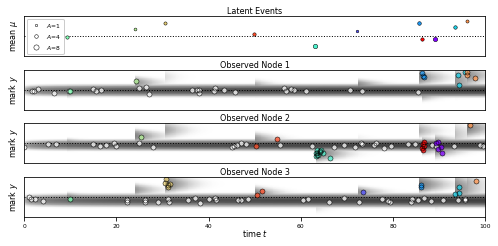

In [29]:
from matplotlib.cm import rainbow

ylim = 1.1 * abs(marks[:, 0]).max()
markersize = lambda w: 2 + 8 * w / 20 

plt.figure(figsize=(6.75, 3.25))
plt.subplot(M+1, 1, 1)
plt.plot([0, T], [0, 0], ':k', lw=1)
for i in range(len(clusters)):
    plt.plot(latent_times[i], latent_mus[i, 0], 'o', mfc=rainbow(i / (len(clusters)-1)), mec='k', mew=0.5, ms=markersize(weights[i]))

# Make a legend
plt.plot(-10, -10, 'o', mfc='w', mec='k', mew=0.5, ms=markersize(1), label="$A$=1")
plt.plot(-10, -10, 'o', mfc='w', mec='k', mew=0.5, ms=markersize(4), label="$A$=4")
plt.plot(-10, -10, 'o', mfc='w', mec='k', mew=0.5, ms=markersize(8), label="$A$=8")
# plt.plot(-10, -10, 'o', mfc='w', mec='k', ms=markersize(20), label="$A$=20")
# plt.plot(-10, -10, 'o', mfc='w', mec='k', ms=markersize(30), label="$A$=30")
plt.legend(loc="upper left", fontsize=6, framealpha=1)

plt.xticks([])
plt.yticks([])
plt.xlim(0, T)
plt.ylim(-ylim, ylim)
plt.title("Latent Events", fontsize=8, y=0.9)
plt.ylabel("mean $\mu$", fontsize=8)

# Compute the intensity on a grid of time and marks
ygrid = np.linspace(-ylim, ylim, 100)
tgrid = np.linspace(0, T, 500)

for m in range(M):
    # Compute the intensity on a grid
    mu_bkgd = true_model.background.mark_backgrounds[m].mu[0]
    sigma_bkgd = np.sqrt(true_model.background.mark_backgrounds[m].Sigma[0, 0])
    lmbda_bkgd = true_model.background.node_background.pi[m] * true_model.lambda0 / T
    intensity = norm.pdf(ygrid, mu_bkgd, sigma_bkgd)[:, None] * lmbda_bkgd * tgrid
    for i in range(len(clusters)):
        mu_clus = latent_mus[i][0]
        sigma_clus = np.sqrt(latent_sigmas[i][0, 0])
        lmbda_clus = latent_pis[i, m] * weights[i]
        t_clus = latent_times[i]
        impulse = norm.pdf(ygrid, mu_clus, sigma_clus)[:, None] * \
                    lmbda_clus * expon.pdf(tgrid - t_clus, scale=tau)[None, :]
        intensity += impulse 
        
    ax = plt.subplot(M+1, 1, m+2)
    plt.imshow(np.log(intensity + 1e-4), aspect="auto", extent=(0, T, ylim, -ylim), cmap="Greys", alpha=0.75)
    plt.plot([0, T], [0, 0], ':k', lw=1)
    
    for z in np.unique(parents):
        color = 'w' if z == -1 else rainbow(z / (len(clusters)-1))
        inds = np.where((parents == z) & (nodes == m))[0]
        plt.plot(times[inds], marks[inds, 0], 'o', mfc=color, mec='None', ms=5, alpha=.75)
        plt.plot(times[inds], marks[inds, 0], 'o', mfc="None", mec='k', mew=.5, ms=5)
    
    if m < M-1:
        plt.xticks([])
    else:
        plt.xlabel("time $t$", fontsize=8, labelpad=-1)
    plt.ylabel("mark $y$", fontsize=8)
    ax.tick_params(labelsize=6)
    
    plt.yticks([])
    plt.xlim(0, T)
    plt.ylim(-ylim, ylim)
    plt.title("Observed Node {}".format(m+1), fontsize=8, y=0.9)
    
plt.tight_layout(pad=0.1)
plt.savefig("figure1.pdf")